#### 先端データ科学特論第2回レポートの解析用プログラム
以下のことを行う
1. 計測したファイルの読み込み
1. 必要な刺激の部分だけ取り出し
1. 該当部分のスパイク波形の取り出し
1. 主成分分析
1. ソーティング

データ量を削減するために16chの内100μm間隔で8ch、WBのデータを取り出し、そのデータに対して300-8000Hzのバンドパスフィルタをかける  
この時の計測では全38種類の刺激を各30回印加したが、問題の簡単化のため,  
刺激は60dBのClick音及び、158VのBurst波を抽出して使用する

In [204]:
%matplotlib notebook
#使用するライブラリの読み込み
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import os
import sys
import scipy.io
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics
import math
import gc
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal,stats
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet,fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import scale
from collections import defaultdict
import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器

In [205]:
#bandpass_filterの設定
def bandpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "band")           #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y                                      #フィルタ後の信号を返す


In [379]:
#使用する計測データ(.matファイル)刺激呈示順番記録(.csvファイル)の読み込み
mat_filepath="./1129_trial1_WB.mat"
csv_filepath="./order/211129_1749_order.csv"
Data=scipy.io.loadmat(mat_filepath)
# 電極の深さ方向のチャンネルマップを記録
# 100μm-800μmまで100μmステップで波形の取得
channel_map=[1,2,5,3,7,8,6,3]

MemoryError: 

In [ ]:
Data.keys()

In [ ]:
#まず波形が取れてそうな3ch(深さ400μm)に着目
WB_wave=Data["WB03"]
# timestamp(刺激が入るタイミングがを取得)単位second
ts=Data["WB03_ts"][0][0]
timestamp=Data["EVT02"]
del Data
gc.collect()

In [ ]:
WB_wave=np.array([WB_wave[i][0] for i in range(len(WB_wave))])

In [ ]:
WB_wave[:10]

In [ ]:
#filter用変数設定
fp=np.array([600,8000])
fs=np.array([400,12000])
gpass=3
gstop=30
samplerate=40000
#バンドパスフィルタをかけた波形を取得
WB_wave=bandpass(WB_wave,samplerate,fp,fs,gpass,gstop)

In [ ]:
# ずれをtsを使って校正
# timestampには刺激がサンプリングレートが40000であるため40000をかけて
# 刺激が印加されるindexを取得
samplerate_timestamp=[(timestamp[i][0]-ts)*40000 for i in range(len(timestamp))]

In [ ]:
samplerate_timestamp=np.array(list(map(int,samplerate_timestamp)))

In [ ]:
#呈示した刺激の種類が格納されている配列
order_table = pd.read_csv(csv_filepath)
#order_table

In [ ]:
click_lists=[]
us_lists=[]
offset=50 #ms
duration=350 #ms
#400ms秒区間の計測波形を取得し結果配列に格納
index=0
for timepoint in samplerate_timestamp:
    wave_info = order_table.iloc[index]
    index+=1
    if wave_info["state"]=="click" and wave_info["db"]==60:
        wave=WB_wave[int(timepoint-offset*samplerate/1000):int(timepoint+duration*samplerate/1000)]
        click_lists.append(wave)
    elif wave_info["state"]=="us_burst" and wave_info["amp"]==1.58 and wave_info["window"]==0:
        wave=WB_wave[int(timepoint-offset*samplerate/1000):int(timepoint+duration*samplerate/1000)]
        us_lists.append(wave)
    else:
        continue


In [207]:
# 波形が取得できているか確認
print(len(click_lists),len(us_lists))

30 30


<IPython.core.display.Javascript object>


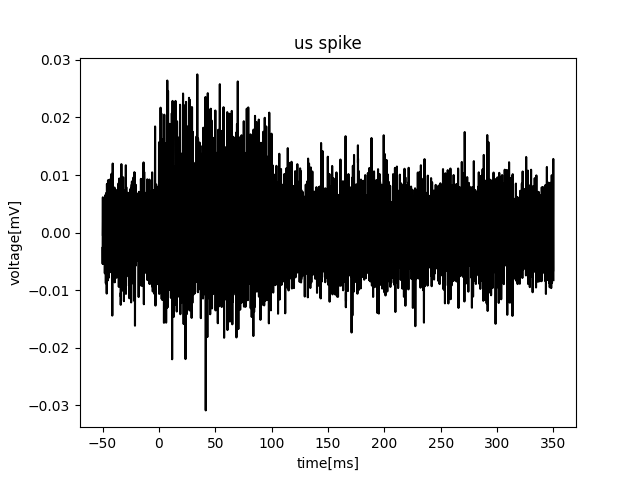

Text(0.5, 1.0, 'us spike')

In [208]:
#各刺激のスパイクの様子を1試行分だけ描画して閾値を決める
fig=plt.figure()
ax=fig.add_subplot(111)
xlim=[-50,350]
single_trial=us_lists[23]
time=np.linspace(xlim[0],xlim[1],len(single_trial))
ax.plot(time,single_trial,color="k")
ax.set_xlabel("time[ms]")
ax.set_ylabel("voltage[mV]")
ax.set_title("us spike")
#ax.set_xlim(41,43)
#plt.savefig("us_spike_i=23.png")

<IPython.core.display.Javascript object>


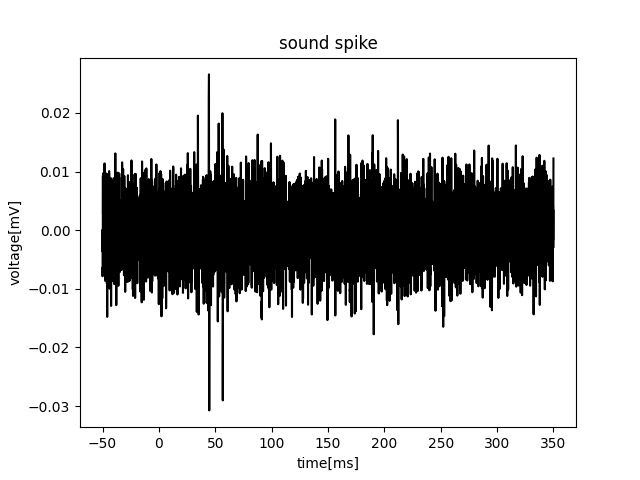

Text(0.5, 1.0, 'sound spike')

In [280]:
#各刺激のスパイクの様子を1試行分だけ描画して閾値を決める
fig=plt.figure()
ax=fig.add_subplot(111)
xlim=[-50,350]
single_trial=click_lists[4]
time=np.linspace(xlim[0],xlim[1],len(single_trial))
ax.plot(time,single_trial,color="k")
ax.set_xlabel("time[ms]")
ax.set_ylabel("voltage[mV]")
ax.set_title("sound spike")
#ax.set_xlim(90,95)
#plt.savefig("sound_spike_i=4.png")

In [211]:
# Spike波形を取得する関数
def get_spikes(wave_list,Th,offset_inus,duration_inus):
    spikes=[]
    global samplerate
    print(samplerate)
    for single_wave in wave_list:
        i=1
        while i<len(single_wave)-int(duration_inus*samplerate/1000000):
            if single_wave[i-1]>Th and single_wave[i]<Th:
                spike=single_wave[i-int(offset_inus*samplerate/1000000):i+int(duration_inus*samplerate/1000000)]
                spikes.append(spike)
                i+=int(duration_inus*samplerate/1000000)
            else:
                i+=1
    return spikes

In [297]:
Th=-0.015
offset_inus=250
duration_inus=1000
click_spikes=get_spikes(click_lists,Th,offset_inus,duration_inus)
us_spikes=get_spikes(us_lists,Th,offset_inus,duration_inus)

40000
40000


In [298]:
print(f"clickのスパイク数:{len(click_spikes)}")
print(f"usのスパイク数:{len(us_spikes)}")

clickのスパイク数:258
usのスパイク数:650


In [299]:
#clickの主成分分析
#まずは各波形の標準化
#click_spikes=stats.zscore(click_spikes)
# for i in range(len(click_spikes)):
#     click_spikes[i]=stats.zscore(click_spikes[i])
#標準化すると寄与率が下がるため棄却

In [366]:
#主成分分析の画像
pca = PCA()
pca.fit(click_spikes)
#データを主成分空間に写像
feature=pca.transform(click_spikes)

In [367]:
# 最初の5レコードに対して各主成分に対する値を描画
pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(click_spikes[0]))]).head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,-0.025880,0.007377,0.003128,-0.003908,0.006526,-0.010988,0.000052,-0.012420,-0.001527,-0.006956,...,3.548164e-10,-6.626438e-11,-4.329965e-12,7.349823e-13,1.696419e-12,4.984867e-13,-1.466126e-14,-4.048220e-15,2.556428e-15,-4.296436e-16
1,0.047876,0.041967,0.003090,-0.000890,-0.015163,-0.000046,-0.011375,-0.014955,0.002346,0.011521,...,-5.504664e-11,1.028317e-10,1.699639e-12,-1.024935e-12,3.324112e-13,-7.021374e-14,-5.820332e-14,2.592712e-14,-1.542644e-15,5.733529e-16
2,-0.014580,-0.003161,-0.007294,0.008833,-0.004070,-0.010744,0.009146,-0.004300,0.007475,-0.004014,...,8.970276e-11,1.093411e-11,-1.259521e-11,7.333932e-12,-2.795267e-13,-9.321020e-14,-9.572024e-14,-6.862537e-15,-1.457819e-15,-1.845966e-16
3,0.004454,-0.002753,0.012779,-0.000592,0.018470,-0.003618,-0.008510,0.000250,-0.001944,-0.004254,...,-1.608718e-11,-5.672753e-11,3.004088e-11,1.891918e-12,-6.261581e-13,1.182697e-13,-6.652738e-14,2.772568e-15,-3.608571e-16,-1.045226e-16
4,0.002433,-0.015524,0.010681,0.000669,0.004702,0.019054,-0.002931,0.001161,0.008730,0.011249,...,1.481607e-10,-1.303619e-13,8.051474e-12,-1.380855e-12,9.334871e-13,4.753239e-14,1.882356e-14,-8.411131e-15,1.709773e-15,-5.671416e-17


In [368]:
#各主成分寄与率を描画
print(pca.explained_variance_ratio_[:5])

[0.3341113  0.12252242 0.10463972 0.0725652  0.05575428]


In [369]:
#累積寄与率を出力
total=0
explained_variance=np.array(list(pca.explained_variance_ratio_))
for i in range(8):
    total+=explained_variance[i]
    print(f"i= {i+1} の累積寄与率は: {total}")
    

i= 1 の累積寄与率は: 0.3341112978494994
i= 2 の累積寄与率は: 0.45663371761308374
i= 3 の累積寄与率は: 0.5612734409047647
i= 4 の累積寄与率は: 0.6338386427012894
i= 5 の累積寄与率は: 0.6895929217850357
i= 6 の累積寄与率は: 0.739801257518035
i= 7 の累積寄与率は: 0.7764272806265243
i= 8 の累積寄与率は: 0.8117279235949503


<IPython.core.display.Javascript object>


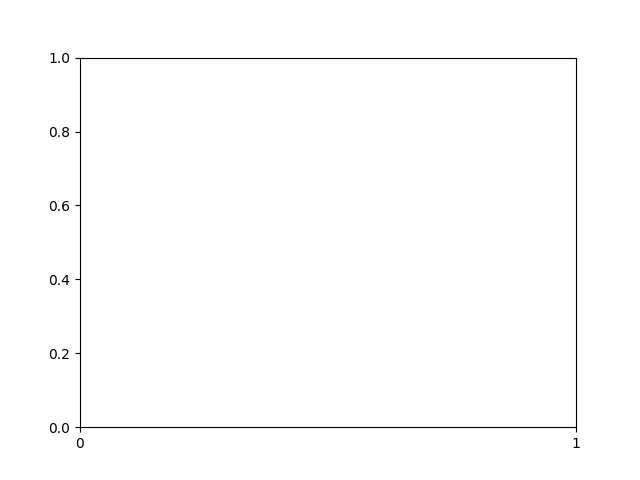

<IPython.core.display.Javascript object>


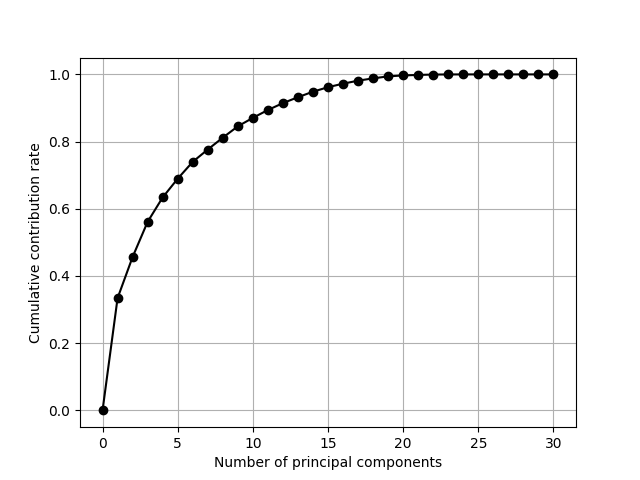

In [322]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot([0] + list( np.cumsum(explained_variance[:30])), "-o",color="k")
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative contribution rate")
plt.grid()
plt.savefig("click_cumlative_contrivution.png")

In [370]:
#第3主成分までをdataとして使用
datas=feature[:,:3]

In [371]:
def clustering_score(datas):
    methods = ["single", "complete", "average", "weighted",
               "centroid", "median", "ward"]
    for method in methods:
        S = pdist(datas,metric="braycurtis")
        Z = linkage(S, method=method)
        c, d = cophenet(Z, S)
        print("{0} {1:.3f}".format(method, c))

In [376]:
clustering_score(datas)

single 0.102
complete 0.256
average 0.359
weighted 0.353
centroid 0.349
median 0.298
ward 0.358


<IPython.core.display.Javascript object>


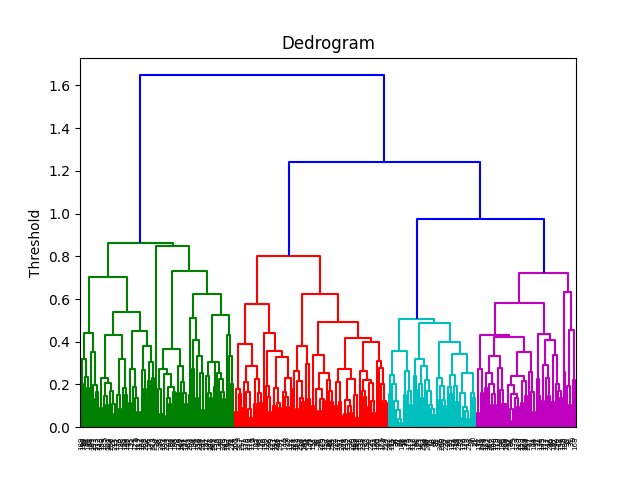

In [373]:
# 階層的クラスタリング
# 結果の作成　Bray-Curtis距離を用いて群平均法でクラスター間の距離を算出
#pdistを使用する
plt.close()
S=pdist(datas,metric="braycurtis")
result=linkage(S,method="average")
dendrogram(result,color_threshold=0.9)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.savefig("sound_dendrogram.png")

In [374]:
#閾値を決めてクラスター分割
cluster_result = fcluster(result, t=0.9, criterion="distance")
d = defaultdict(list)
for i, r in enumerate(cluster_result):
    d[r].append(i)
for k, v in d.items():
    print(k, v)

3 [0, 11, 13, 15, 21, 26, 29, 33, 34, 36, 39, 41, 48, 54, 58, 62, 64, 65, 68, 69, 73, 75, 85, 91, 95, 97, 99, 110, 115, 118, 120, 121, 148, 155, 161, 175, 176, 209, 210, 217, 218, 227, 242, 246, 247, 253]
1 [1, 5, 6, 10, 23, 24, 25, 37, 44, 45, 47, 49, 50, 57, 59, 72, 74, 76, 78, 79, 84, 88, 89, 93, 96, 98, 101, 102, 113, 125, 126, 129, 130, 131, 135, 142, 143, 144, 146, 147, 156, 157, 158, 164, 165, 166, 167, 171, 173, 181, 182, 183, 184, 185, 188, 189, 190, 194, 196, 199, 203, 206, 208, 213, 215, 222, 223, 226, 228, 231, 232, 233, 238, 240, 241, 243, 249, 250, 251, 254]
4 [2, 9, 12, 14, 17, 18, 19, 22, 30, 31, 35, 52, 56, 60, 66, 67, 70, 82, 83, 100, 104, 106, 109, 119, 127, 136, 137, 138, 139, 145, 154, 159, 162, 168, 170, 172, 174, 179, 180, 186, 187, 195, 197, 204, 219, 229, 237, 245, 248, 252, 256, 257]
2 [3, 4, 7, 8, 16, 20, 27, 28, 32, 38, 40, 42, 43, 46, 51, 53, 55, 61, 63, 71, 77, 80, 81, 86, 87, 90, 92, 94, 103, 105, 107, 108, 111, 112, 114, 116, 117, 122, 123, 124, 128, 132

<IPython.core.display.Javascript object>


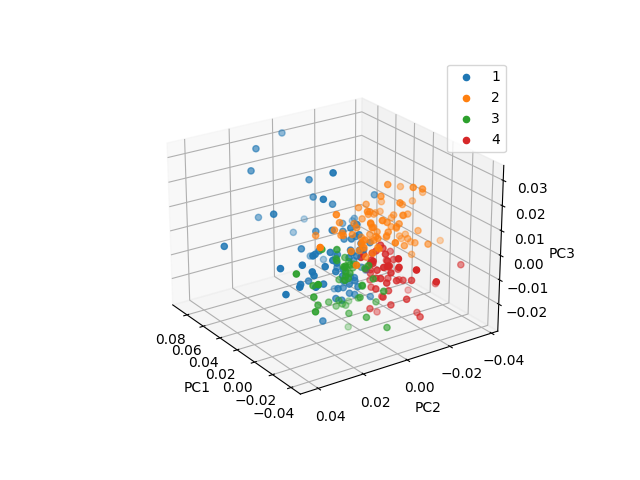

In [351]:
#各パラメータデータに入れる
X=datas[:,0]
Y=datas[:,1]
Z=datas[:,2]

# グラフの枠を作成
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

# X,Y,Z軸にラベルを設定
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
#ax.set_xlim(0,20000)
#ax.set_zlim(0,7500)

#各クラスターに対して散布図の描画
for key in sorted(d):
    values=d[key]
    x=[X[value] for value in values]
    y=[Y[value] for value in values]
    z=[Z[value] for value in values]
    ax.scatter(x,y,z,label=str(key))
ax.view_init(elev=20, azim=240)
plt.legend()
#plt.show()
plt.savefig("pca_result_click.png")

In [311]:
fig.clear()
plt.close(fig)
del fig
gc.collect()


70321

<IPython.core.display.Javascript object>


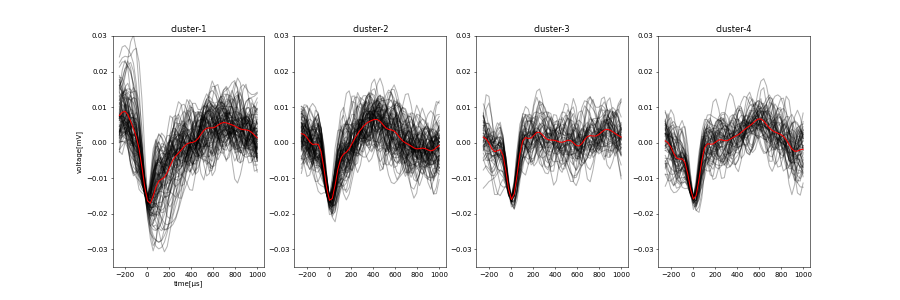

In [375]:
#各成分について波形を描画する
fig=plt.figure(figsize=(18,6),dpi=50)
for cluster,waves in d.items():
    ax=fig.add_subplot(1,len(d.keys()),cluster)
    ax.set_title(f"cluster-{cluster}")
    if cluster==1:
        ax.set_ylabel("voltage[mV]")
        ax.set_xlabel("time[μs]")
    ax.set_ylim(-0.035,0.03)
    average_spike=np.zeros(len(click_spikes[0]))
    for wave_ind in waves:
        spike=click_spikes[wave_ind]
        average_spike+=spike
        time=np.linspace(-offset_inus,duration_inus,len(spike))
        ax.plot(time,spike,color="k",alpha=0.3)
    average_spike/=len(waves)
    ax.plot(time,average_spike,color="r")
plt.savefig("each_cluster_wave_sound.png")

### 同様に超音波刺激に対しても主成分分析を行う。

In [377]:
#主成分分析の画像
pca = PCA()
pca.fit(us_spikes)
#データを主成分空間に写像
feature=pca.transform(click_spikes)

In [378]:
#累積寄与率を出力
total=0
explained_variance=np.array(list(pca.explained_variance_ratio_))
for i in range(8):
    total+=explained_variance[i]
    print(f"i= {i+1} の累積寄与率は: {total}")

i= 1 の累積寄与率は: 0.34557679922619117
i= 2 の累積寄与率は: 0.5193688681035691
i= 3 の累積寄与率は: 0.6365593719565232
i= 4 の累積寄与率は: 0.724694344196737
i= 5 の累積寄与率は: 0.7844883158141456
i= 6 の累積寄与率は: 0.8260193005123346
i= 7 の累積寄与率は: 0.8562555655445623
i= 8 の累積寄与率は: 0.8822626681566086


<IPython.core.display.Javascript object>


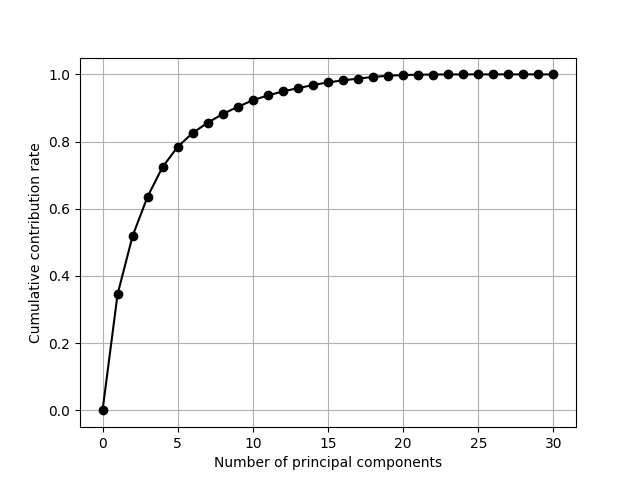

In [360]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot([0] + list( np.cumsum(explained_variance[:30])), "-o",color="k")
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative contribution rate")
plt.grid()
plt.savefig("us_cumlative_contrivution.png")

In [361]:
#第3主成分までをdataとして使用
datas=feature[:,:3]

In [362]:
clustering_score(datas)

single 0.015
complete 0.353
average 0.389
weighted 0.375
centroid 0.379
median 0.287
ward 0.393


<IPython.core.display.Javascript object>


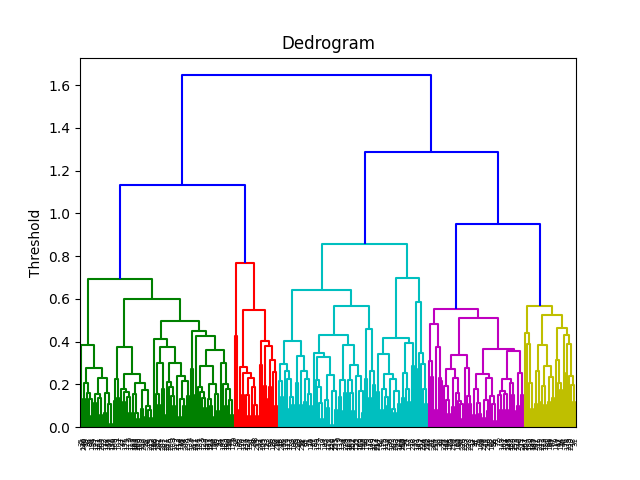

In [363]:
# 階層的クラスタリング
# 結果の作成　Bray-Curtis距離を用いて群平均法でクラスター間の距離を算出
#pdistを使用する
plt.close()
S=pdist(datas,metric="braycurtis")
result=linkage(S,method="average")
dendrogram(result,color_threshold=0.9)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.savefig("us_dendrogram.png")

In [364]:
#閾値を決めてクラスター分割
cluster_result = fcluster(result, t=0.9, criterion="distance")
d = defaultdict(list)
for i, r in enumerate(cluster_result):
    d[r].append(i)
for k, v in d.items():
    print(k, v)

3 [0, 7, 13, 19, 20, 21, 26, 27, 29, 32, 34, 36, 39, 42, 46, 55, 65, 66, 68, 73, 77, 78, 83, 85, 87, 90, 91, 94, 95, 102, 103, 104, 107, 108, 110, 112, 115, 117, 120, 121, 132, 133, 134, 137, 139, 140, 141, 149, 151, 152, 153, 159, 160, 168, 169, 170, 176, 177, 192, 193, 195, 198, 202, 203, 209, 214, 217, 218, 220, 224, 233, 234, 235, 237, 243, 248, 250, 252]
1 [1, 3, 4, 5, 6, 22, 23, 25, 35, 44, 45, 47, 49, 57, 60, 71, 74, 79, 84, 86, 88, 89, 93, 96, 98, 101, 113, 114, 116, 122, 125, 126, 127, 129, 131, 135, 136, 143, 144, 146, 147, 150, 156, 157, 158, 164, 165, 166, 171, 172, 173, 178, 181, 183, 184, 185, 188, 189, 190, 194, 196, 197, 199, 200, 201, 205, 206, 207, 208, 211, 213, 215, 216, 222, 230, 232, 240, 241, 249, 251]
4 [2, 10, 12, 14, 15, 24, 33, 37, 41, 48, 50, 51, 54, 56, 58, 59, 62, 64, 69, 70, 72, 75, 97, 99, 100, 106, 118, 130, 142, 148, 155, 161, 162, 175, 182, 204, 210, 223, 225, 226, 227, 228, 231, 238, 245, 246, 247, 253, 256, 257]
2 [8, 9, 16, 28, 30, 38, 43, 53, 61, 

<IPython.core.display.Javascript object>


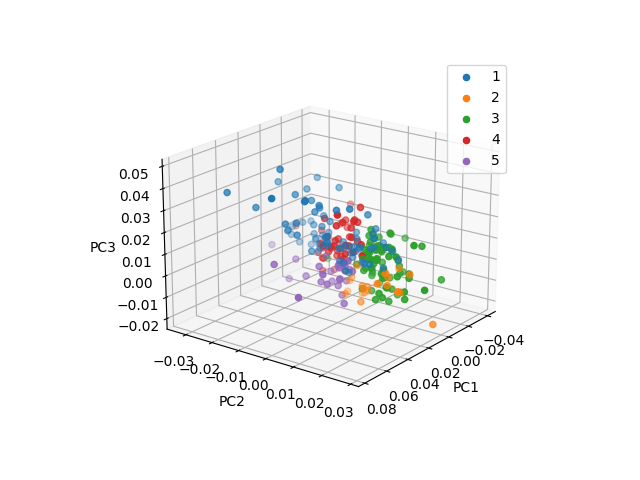

In [344]:
#各パラメータデータに入れる
X=datas[:,0]
Y=datas[:,1]
Z=datas[:,2]

# グラフの枠を作成
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

# X,Y,Z軸にラベルを設定
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
#ax.set_xlim(0,20000)
#ax.set_zlim(0,7500)

#各クラスターに対して散布図の描画
for key in sorted(d):
    values=d[key]
    x=[X[value] for value in values]
    y=[Y[value] for value in values]
    z=[Z[value] for value in values]
    ax.scatter(x,y,z,label=str(key))
ax.view_init(elev=20, azim=240)
plt.legend()
#plt.show()
plt.savefig("pca_result_us.png")

<IPython.core.display.Javascript object>


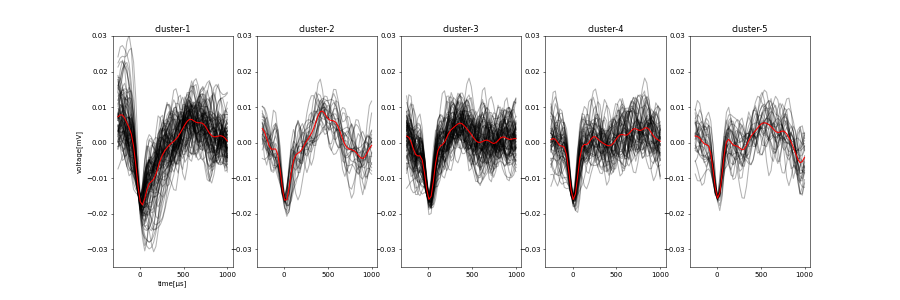

In [365]:
#各成分について波形を描画する
fig=plt.figure(figsize=(18,6),dpi=50)
for cluster,waves in d.items():
    ax=fig.add_subplot(1,len(d.keys()),cluster)
    ax.set_title(f"cluster-{cluster}")
    if cluster==1:
        ax.set_ylabel("voltage[mV]")
        ax.set_xlabel("time[μs]")
    ax.set_ylim(-0.035,0.03)
    average_spike=np.zeros(len(click_spikes[0]))
    for wave_ind in waves:
        spike=click_spikes[wave_ind]
        average_spike+=spike
        time=np.linspace(-offset_inus,duration_inus,len(spike))
        ax.plot(time,spike,color="k",alpha=0.3)
    average_spike/=len(waves)
    ax.plot(time,average_spike,color="r")
plt.savefig("each_cluster_wave_us.png")